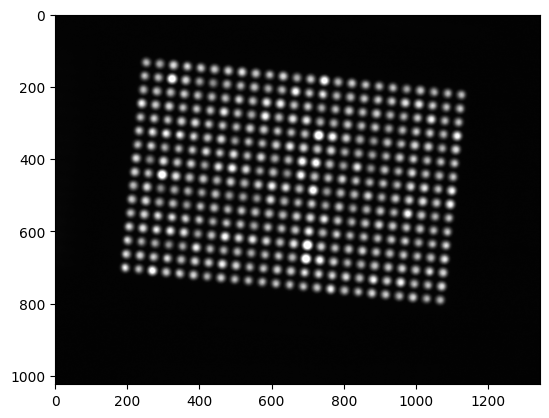

In [373]:
"""Load image"""

IMAGE_PATH = "/Users/antoinegerardin/Documents/data/rt-cetsa/Data for Nick/20210318 LDHA compound plates/20210318 LDHA compound plate 1 6K cells/1.tif"

PLATE_SIZE = 384
PLATE_DIMS = (24,16)
WELL_RADIUS = 10
WELL_RADIUS_TOLERANCE = 4


from bfio import BioReader
from matplotlib import pyplot as plt

with BioReader(IMAGE_PATH) as br:
    bpp = br.bpp
    image = br[:].squeeze()
    plt.imshow(image, cmap='gray')



In [383]:
"""Extract wells from image"""

from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
import numpy as np

from skimage.draw import disk

def hough_transform_circles(image):
    # TODO CHECK not sure how robust this is
    edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

    # plt.imshow(edges, cmap='gray')
    # plt.show()

    # TODO values are tied to the scale, not good
    hough_radii = np.arange(WELL_RADIUS - WELL_RADIUS_TOLERANCE  , WELL_RADIUS + WELL_RADIUS_TOLERANCE, 1)
    hough_res = hough_circle(edges, hough_radii, full_output=False)

    accums, cx, cy, radii = hough_circle_peaks(
        hough_res, hough_radii,
        min_xdistance=WELL_RADIUS * 2,
        min_ydistance=WELL_RADIUS * 2,
        total_num_peaks=PLATE_SIZE
    )

    return (accums, cx, cy, radii)

accums, cx, cy, radii = hough_transform_circles(image)



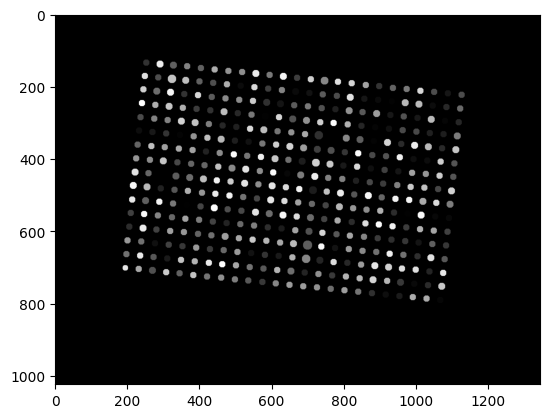

{0: (767, 339), 1: (296, 444), 2: (364, 528), 3: (975, 552), 4: (581, 282), 5: (931, 241), 6: (881, 351), 7: (345, 334), 8: (885, 313), 9: (1078, 295), 10: (1065, 791), 11: (642, 441), 12: (1051, 560), 13: (1089, 564), 14: (993, 746), 15: (665, 214), 16: (893, 237), 17: (513, 198), 18: (1029, 405), 19: (1044, 253), 20: (232, 322), 21: (991, 401), 22: (914, 776), 23: (873, 427), 24: (276, 634), 25: (923, 317), 26: (535, 353), 27: (703, 218), 28: (542, 661), 29: (774, 647), 30: (1005, 632), 31: (623, 248), 32: (949, 435), 33: (1086, 219), 34: (855, 234), 35: (927, 279), 36: (1002, 287), 37: (269, 326), 38: (797, 419), 39: (618, 669), 40: (310, 676), 41: (952, 780), 42: (626, 593), 43: (713, 487), 44: (683, 407), 45: (1074, 332), 46: (497, 350), 47: (775, 263), 48: (501, 312), 49: (1036, 329), 50: (832, 461), 51: (417, 380), 52: (292, 482), 53: (474, 578), 54: (1035, 712), 55: (690, 715), 56: (732, 681), 57: (847, 309), 58: (1116, 299), 59: (463, 308), 60: (808, 688), 61: (505, 274), 62: 

In [375]:
"""Create a mask (ignore overlapping circles if needed)."""

well_index = {}

def create_labeled_mask(image, cy, cx, radii):
    mask = np.zeros(image.shape, dtype=int)
    id = 0

    for center_y, center_x, radius in zip(cy, cx, radii):
        rr, cc = disk((center_y, center_x), radius, shape=image.shape)
        if mask[center_y, center_x] != 0:
            mask[rr, cc] = mask[center_y, center_x]
        else:
            mask[rr, cc] = id
            well_index[id] = (center_x, center_y)
            id += 1
            
    return mask


mask = create_labeled_mask(image, cy, cx, radii)

plt.imshow(mask, cmap='gray')
plt.show()

assert len(well_index) == 384



print(well_index)

In [376]:
"""Estimate background correction."""

import math 

background = image - mask
background_value_1 = np.mean(background)
background_value_2 = np.ma.median(background)

cutoff = math.ceil(5 * np.prod(background.shape) / 100)
background_sorted = np.sort(background)
background_value_3 = background_sorted[:cutoff].mean()

print(f"background estimation :{background_value_1}, {background_value_2}, {background_value_3}")

background estimation :33203.207108997165, 32879.0, 33203.207108997165


In [377]:
"""Compute mean intensity for each well."""

background_value = background_value_2

unqID,idx,IDsums = np.unique(mask,return_counts=True,return_inverse=True)
values_sums = np.bincount(idx,image.ravel())
value_means = values_sums / IDsums 
value_means_corrected = value_means - background_value
object_index = {i:(IDsums[itr],value_means_corrected[itr]) for itr,i in enumerate(unqID) if i!=0}


print(np.min(value_means_corrected))
print(np.max(value_means_corrected))



166.09265351865906
3666.029748283756


In [378]:
min_x = np.argmin(cx)
max_x = np.argmax(cx)
min_y = np.argmin(cy)
max_y = np.argmax(cy)

# TODO only work in this configuration! Certain orientations  would fail!

corners = [[cx[min_x],cy[min_x]], [cx[max_x],cy[max_x]], [cx[min_y],cy[min_y]], [cx[max_y],cy[max_y]]]

corners_top = sorted(corners , key=lambda c : c[1])
corners_left = sorted(corners , key=lambda c : c[0])

top_left, top_right = corners_top[0], corners_top[1]

slope = (top_left[1] - top_right[1]) / (top_left[0] - top_right[0]);
angle = math.atan(slope)

print(f"approx rotation angle: {angle}")

approx rotation angle: 0.10171201438786154


approx width: 930
approx height: 657


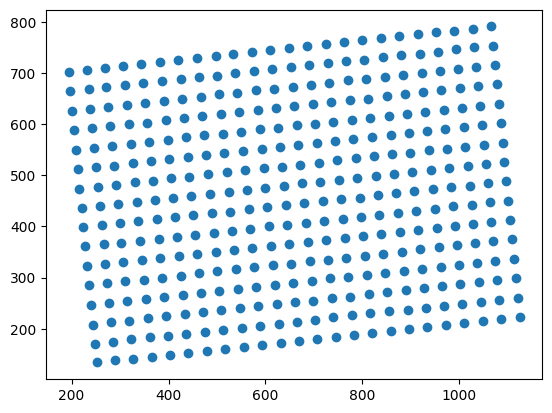

In [379]:
"""Check current orientation."""

wells_centers = np.array([val for key, val in well_index.items()])

width, height = max - min
print(f"approx width: {width}")
print(f"approx height: {height}")

y = wells_centers[:,1]
x = wells_centers[:,0]

plt.scatter(x,y)



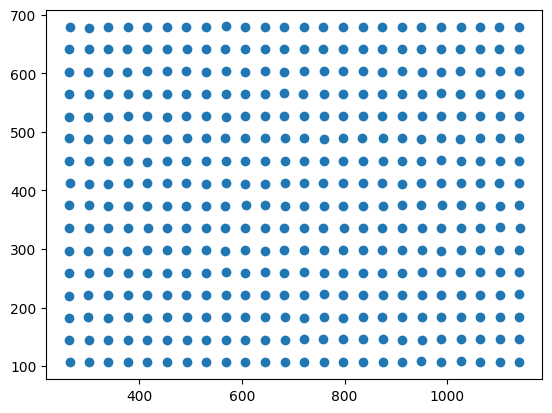

In [380]:
"""Rotate the wells so we can order them based on their coordinates."""

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle is in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

rotated_well_index = {key: rotate(origin=(0,0), point=wells_center, angle=-angle) for key, wells_center in well_index.items()}

rotated = np.array([val for val in rotated_well_index.values()])

y = rotated[:,1]
x = rotated[:,0]

plt.scatter(x,y)

In [381]:
"""Order wells based on their coordinates."""

rotated_wells = {(round(value[1]), round(value[0])): key for key,value in rotated_well_index.items()}
rotated_wells = sorted(rotated_wells.items(), key = lambda kv: kv[0][1])

def divide_chunks(l, n): 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

x = list(divide_chunks(rotated_wells, 16)) 


sorted_row_cols = []

for row in x:
    sorted_row = sorted(row, key = lambda kv: kv[0][0])
    sorted_row_cols.append(sorted_row)

In [382]:
"""Retrieved computed mean intensity for each well and save to csv."""

mean_intensities = [] 

for row in sorted_row_cols:
    for col in row:
        index = col[1]
        val = value_means_corrected[index]
        mean_intensities.append(round(val))

mean_intensities = np.array(mean_intensities, dtype=int).reshape(16,24)
np.set_printoptions(suppress=True)
np.savetxt("process_plate_example.csv", mean_intensities, delimiter=",", fmt='%d')